# Классификация временных рядов

## Подготовка и очистка данных

In [ ]:
!pip install PyWavelets

In [ ]:
!pip install phik

In [ ]:
!pip install pyentrp

In [ ]:
!pip install catboost

In [ ]:
import datetime
import random

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from scipy.fft import fft
from scipy.stats import uniform, randint
import pywt
import phik
from scipy.stats import skew, kurtosis
from tqdm import tqdm
from pyentrp import entropy as ent
from scipy.stats import linregress

from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import warnings

warnings.filterwarnings('ignore')

In [ ]:
df_train = pd.read_parquet('train.parquet', engine='pyarrow')
df_test = pd.read_parquet('test.parquet', engine='pyarrow')

In [ ]:
df_train.head()

In [ ]:
df_train['values'].apply(len).equals(df_train['dates'].apply(len))

True

In [ ]:
print(f'missing values: {df_train.isna().sum().sum() + df_test.isna().sum().sum()}')

missing values: 0


In [ ]:
df_train['values'].apply(sum).isna().sum()

88

In [ ]:
df_train = df_train[~df_train['values'].apply(sum).isna()]

Временные ряды имеют различные длины, но для соответсвующих пар длины совпадают, и пропусков вообще нет

## EDA

<Axes: xlabel='label', ylabel='count'>

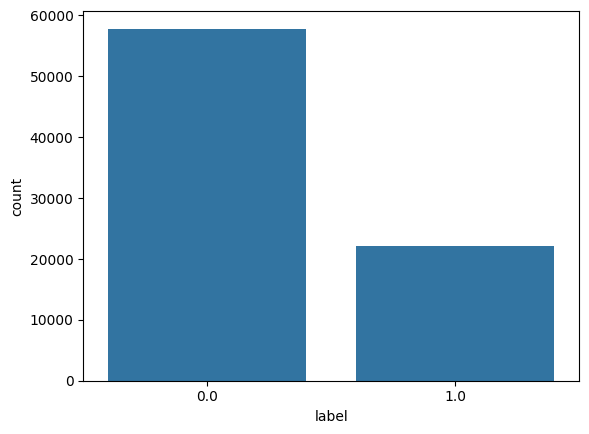

In [ ]:
sns.countplot(x='label', data=df_train)

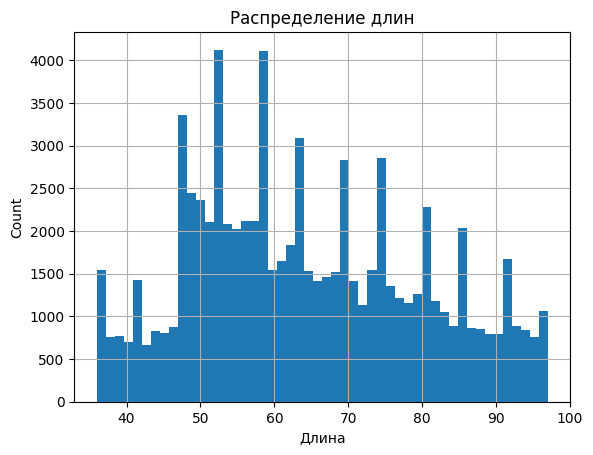

In [ ]:
df_train['length'] = df_train['values'].apply(len)
df_train['length'].hist(bins=50)
plt.title('Распределение длин')
plt.xlabel('Длина')
plt.ylabel('Count')
plt.show()

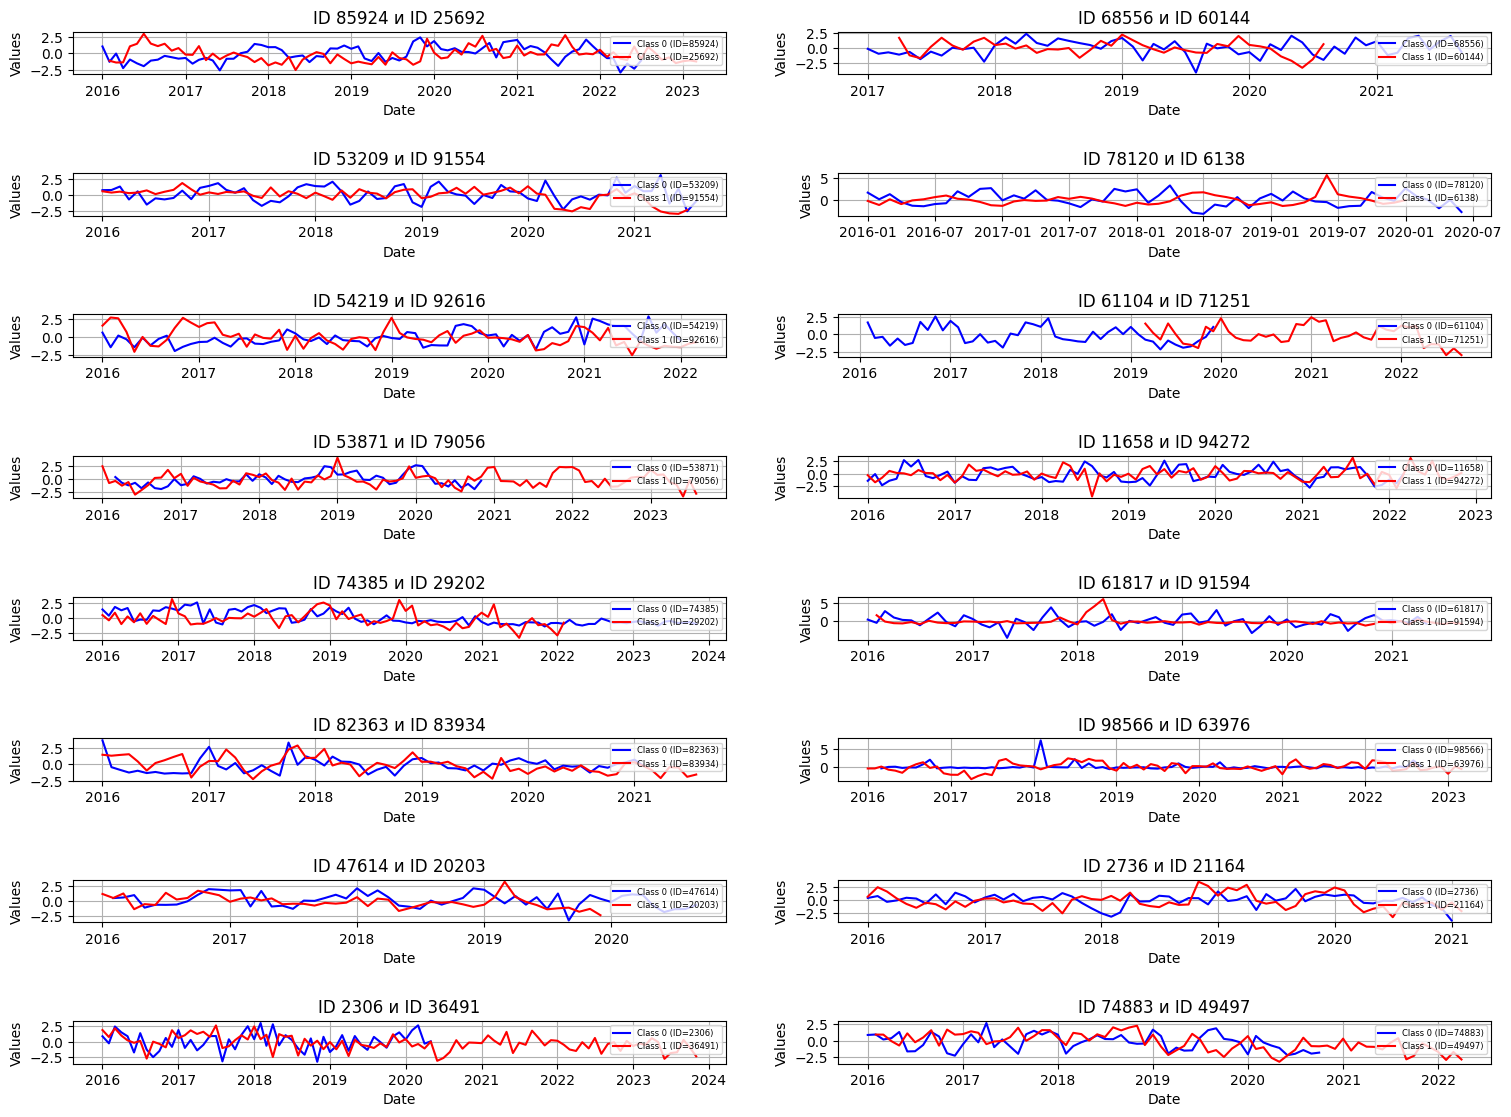

In [ ]:
# отрисуем пары рядов
num_plots = 16
rows = 8
cols = 2

class_0_indices = df_train[df_train['label'] == 0].index
class_1_indices = df_train[df_train['label'] == 1].index

fig, axes = plt.subplots(rows, cols, figsize=(16, 12))
plt.tight_layout(pad=5.0)

axes = axes.ravel()
for i in range(num_plots):
    random_class_0 = random.choice(class_0_indices)
    random_class_1 = random.choice(class_1_indices)

    dates_0 = df_train.loc[random_class_0, 'dates']
    values_0 = df_train.loc[random_class_0, 'values']

    dates_1 = df_train.loc[random_class_1, 'dates']
    values_1 = df_train.loc[random_class_1, 'values']
    ax = axes[i]

    ax.plot(dates_0, values_0, label=f'Class 0 (ID={df_train.loc[random_class_0, "id"]})', color='blue')
    ax.plot(dates_1, values_1, label=f'Class 1 (ID={df_train.loc[random_class_1, "id"]})', color='red')
    ax.set_title(f'ID {df_train.loc[random_class_0, "id"]} и ID {df_train.loc[random_class_1, "id"]}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Values')
    ax.legend(loc='upper right', fontsize=6)
    ax.grid(True)

for j in range(num_plots, rows * cols):
    fig.delaxes(axes[j])

plt.show()

Ярко выраженных закономерностей не видно, но можно заметить, что класс 1 либо слишком резко меняется в целом, либо слишком плавный стационарный, в то время как класс 0 ведет себя более спокойно, не уходя в крайности

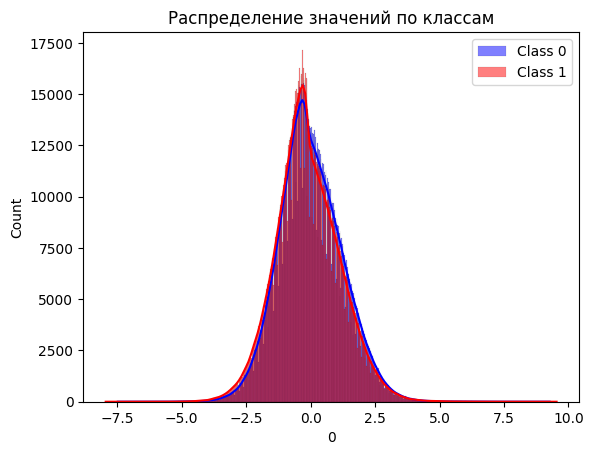

In [ ]:
class_0 = pd.DataFrame([val for sublist in df_train[df_train['label'] == 0]['values'] for val in sublist])
class_1 = pd.DataFrame([val for sublist in df_train[df_train['label'] == 1]['values'] for val in sublist])
class_0_balanced = class_0.sample(n=len(class_1), random_state=42)

sns.histplot(class_0_balanced[0], kde=True, color='blue', label='Class 0')
sns.histplot(class_1[0], kde=True, color='red', label='Class 1')
plt.legend()
plt.title('Распределение значений по классам')
plt.show()

In [ ]:
def calculate_mean_and_std(series):
    means = [np.mean(val) for val in series]
    stds = [np.std(val) for val in series]
    return means, stds

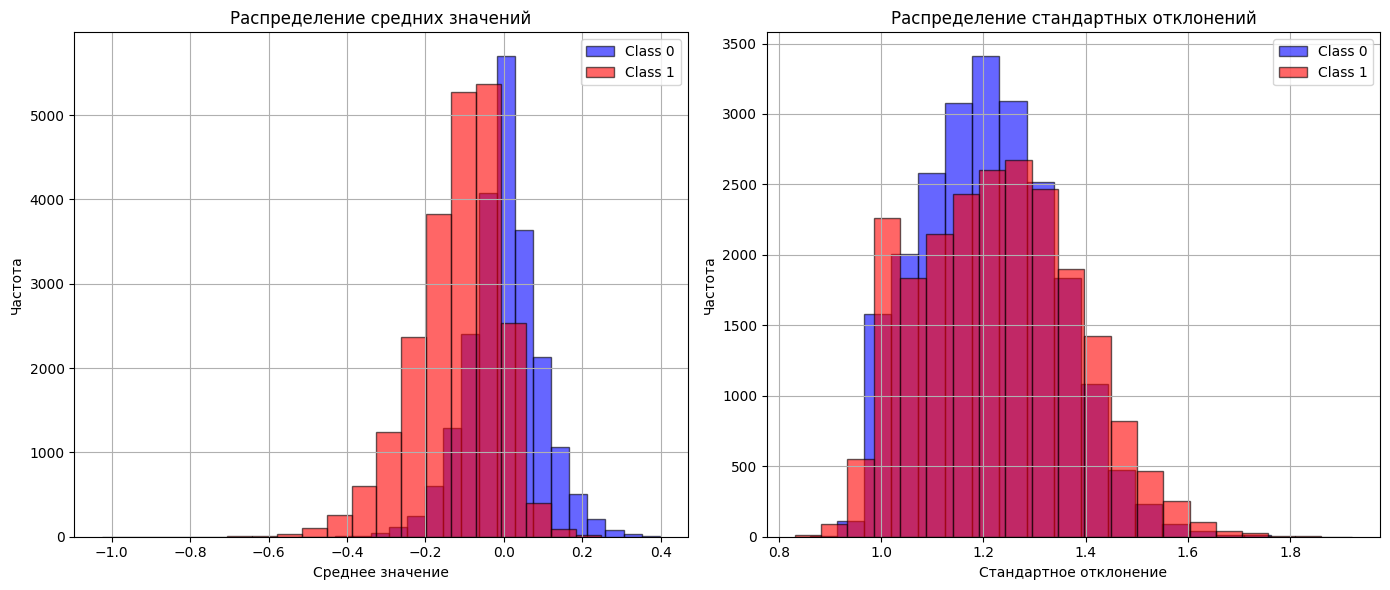

In [ ]:
class_0_values = df_train[df_train['label'] == 0]['values']
class_1_values = df_train[df_train['label'] == 1]['values']

class_0_values_balanced = class_0_values.sample(n=len(class_1_values), random_state=42)

means_0, stds_0 = calculate_mean_and_std(class_0_values_balanced)
means_1, stds_1 = calculate_mean_and_std(class_1_values)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.hist(means_0, bins=20, alpha=0.6, label='Class 0', color='blue', edgecolor='black')
plt.hist(means_1, bins=20, alpha=0.6, label='Class 1', color='red', edgecolor='black')
plt.title('Распределение средних значений')
plt.xlabel('Среднее значение')
plt.ylabel('Частота')
plt.legend(loc='upper right')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(stds_0, bins=20, alpha=0.6, label='Class 0', color='blue', edgecolor='black')
plt.hist(stds_1, bins=20, alpha=0.6, label='Class 1', color='red', edgecolor='black')
plt.title('Распределение стандартных отклонений')
plt.xlabel('Стандартное отклонение')
plt.ylabel('Частота')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

Количество объектов нулевого класса было обрезано до количества объектов в первом классе, **средние первого класса смещены от нулевого класса влево от нуля**

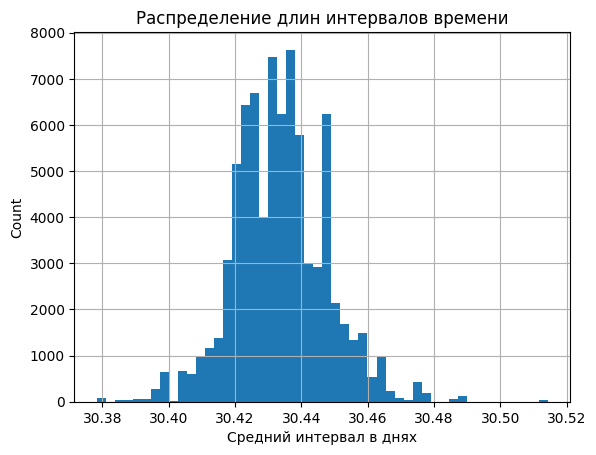

In [ ]:
df_train['date_intervals'] = df_train['dates'].apply(lambda x: pd.Series(pd.to_datetime(x)).diff().dt.days.tolist()[1:])
df_train['mean_interval'] = df_train['date_intervals'].apply(lambda x: np.mean(x) if len(x) > 0 else np.nan)
df_train['mean_interval'].hist(bins=50)
plt.title('Распределение длин интервалов времени')
plt.xlabel('Средний интервал в днях')
plt.ylabel('Count')
plt.show()

Временные интервалы всегда размером в месяц

## Исследуем на стационарность тестом ADF

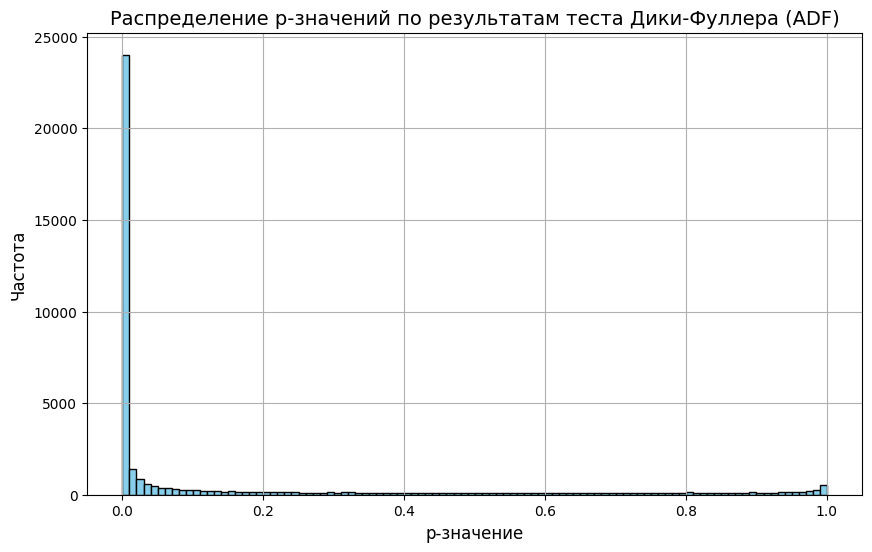

Количество NaN p-значений: 0
class  stationary
0.0    False          5260
       True          14740
1.0    False          7424
       True          12576
dtype: int64


In [ ]:
def check_stationarity(df, max_samples=20000):
    stationarity_results = {"id": [], "class": [], "stationary": [], "p_value": [],"values": []}


    for label_class in df['label'].unique():
        class_data = df[df['label'] == label_class]
        class_data = class_data.sample(n=min(max_samples, len(class_data)), random_state=42)  # Выбираем случайные 5000 или меньше, если рядов меньше 5000

        for index, row in class_data.iterrows():
            values = np.array(row['values'])


            if len(np.unique(values)) > 1:
                # тест Дики-Фуллера
                try:
                    adf_result = adfuller(values)
                    p_value = adf_result[1]  # p-значение теста
                    is_stationary = p_value < 0.05
                except Exception as e:
                    p_value = np.nan
                    is_stationary = False
            else:
                p_value = np.nan
                is_stationary = False


            stationarity_results['id'].append(row['id'])
            stationarity_results['class'].append(label_class)
            stationarity_results['stationary'].append(is_stationary)
            stationarity_results['p_value'].append(p_value)
            stationarity_results['values'].append(values)


    return pd.DataFrame(stationarity_results)


df_stationarity = check_stationarity(df_train, max_samples=20000)


plt.figure(figsize=(10, 6))
plt.hist(df_stationarity['p_value'].dropna(), bins=100, color='skyblue', edgecolor='black')
plt.title('Распределение p-значений по результатам теста Дики-Фуллера (ADF)', fontsize=14)
plt.xlabel('p-значение', fontsize=12)
plt.ylabel('Частота', fontsize=12)
plt.grid(True)
plt.show()


print("Количество NaN p-значений:", df_stationarity['p_value'].isna().sum())
print(df_stationarity.groupby(['class', 'stationary']).size())

Большая часть рядов обоих классов стационарна (60-70%), стационарных рядов в классе 1 больше

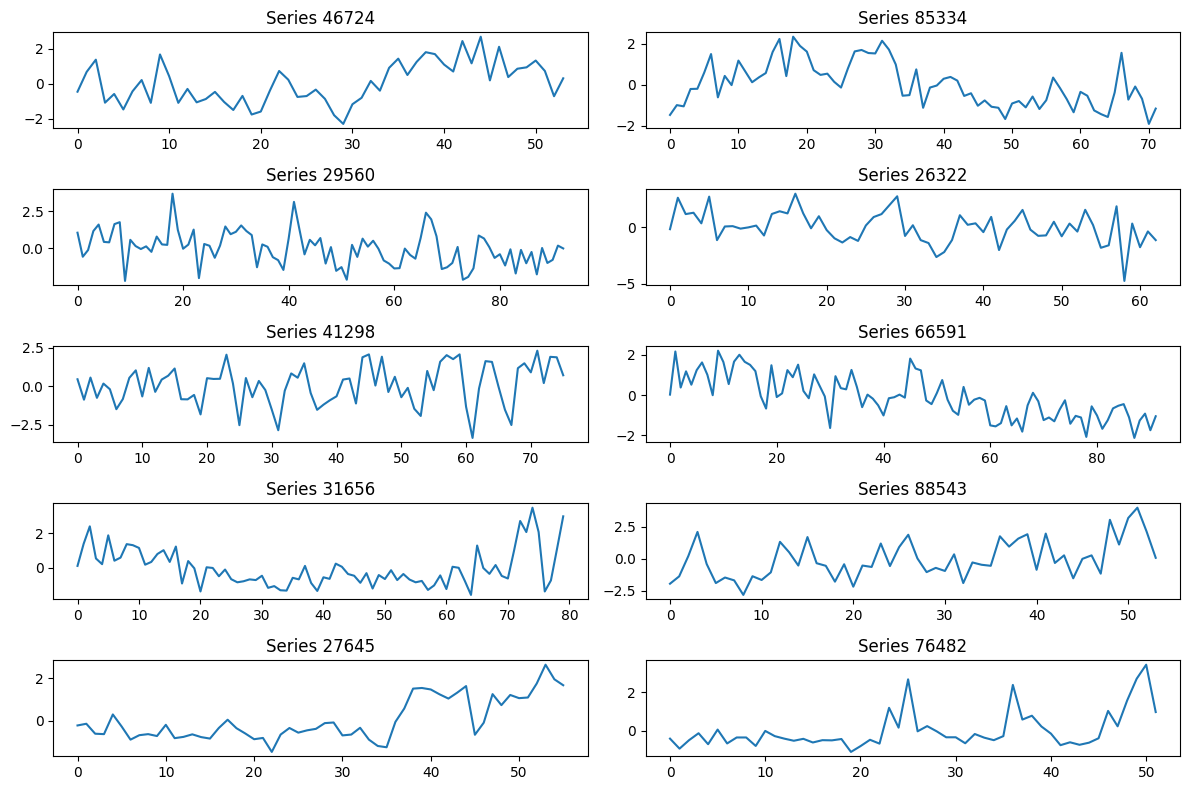

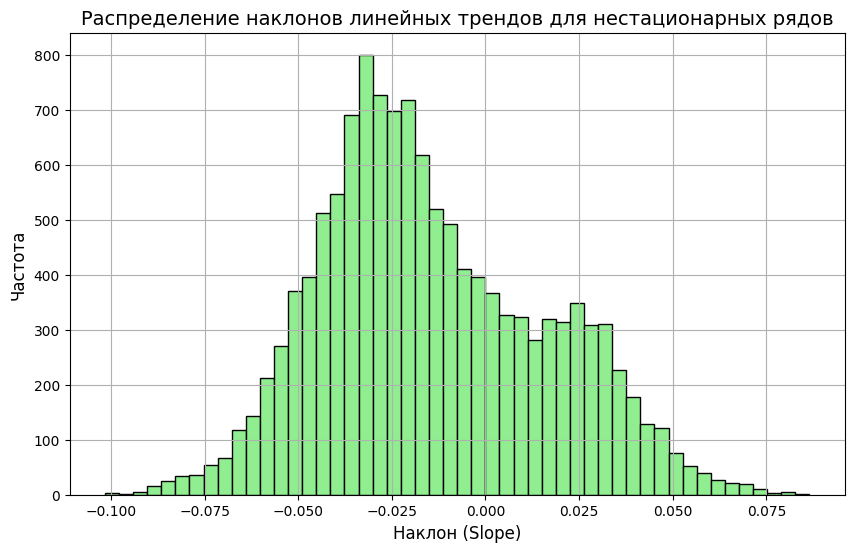

has_trend
False     2043
True     10641
dtype: int64


In [ ]:
non_stationary_df = df_stationarity[df_stationarity['stationary'] == False]

# 10 нестационарных рядов
plt.figure(figsize=(12, 8))
for i, values in enumerate(non_stationary_df['values'].head(10)):
    plt.subplot(5, 2, i+1)
    plt.plot(values)
    plt.title(f"Series {non_stationary_df['id'].iloc[i]}")
plt.tight_layout()
plt.show()

def check_trends(df):
    trend_results = {"id": [], "class": [], "has_trend": [], "slope": []}

    for index, row in df.iterrows():
        values = np.array(row['values'])
        X = np.arange(len(values)).reshape(-1, 1)
        y = values

        model = LinearRegression()
        model.fit(X, y)
        slope = model.coef_[0]
        has_trend = abs(slope) > 0.01

        trend_results['id'].append(row['id'])
        trend_results['class'].append(row['class'])
        trend_results['has_trend'].append(has_trend)
        trend_results['slope'].append(slope)

    return pd.DataFrame(trend_results)

df_trends = check_trends(non_stationary_df)
plt.figure(figsize=(10, 6))
plt.hist(df_trends['slope'], bins=50, color='lightgreen', edgecolor='black')
plt.title('Распределение наклонов линейных трендов для нестационарных рядов', fontsize=14)
plt.xlabel('Наклон (Slope)', fontsize=12)
plt.ylabel('Частота', fontsize=12)
plt.grid(True)
plt.show()



У большей части нестационарных рядов присутвует тренд, наклоненный вниз

### Посчитаем наклоны линейных трендов в целом по классам:

<ipython-input-143-2e9226e6b5d6>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['trend_slope'] = df_train['values'].apply(compute_trend)


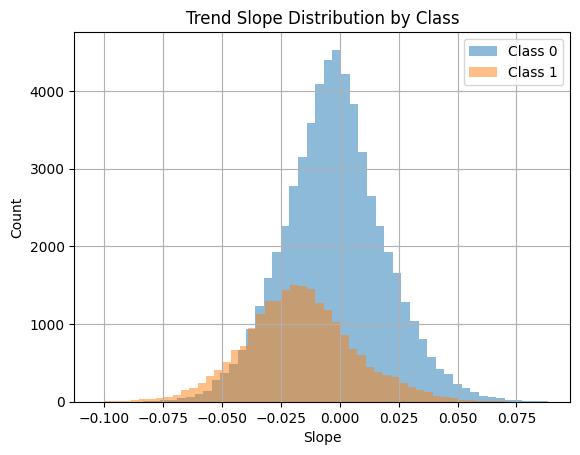

In [ ]:
def compute_trend(values):
    values = np.array(values)

    X = np.arange(len(values)).reshape(-1, 1)

    model = LinearRegression().fit(X, values)
    return model.coef_[0]

df_train['trend_slope'] = df_train['values'].apply(compute_trend)

# Сравнение линейных трендов для разных классов
df_train[df_train['label'] == 0]['trend_slope'].hist(bins=50, alpha=0.5, label='Class 0')
df_train[df_train['label'] == 1]['trend_slope'].hist(bins=50, alpha=0.5, label='Class 1')
plt.title('Trend Slope Distribution by Class')
plt.xlabel('Slope')
plt.ylabel('Count')
plt.legend()
plt.show()

Тренды у объектов класса 1 наклонены в среднем ниже

### Автокорреляции

In [ ]:
def compute_acf(values, nlags=20):
    values = np.array(values)
    return acf(values, nlags=nlags, fft=True)

In [ ]:
df_train['acf_values'] = df_train['values'].apply(lambda x: compute_acf(x, nlags=20))

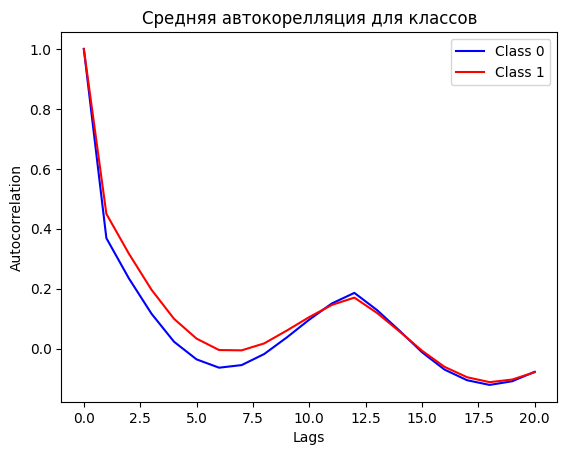

In [ ]:
acf_class_0 = np.nanmean(np.stack(df_train[df_train['label'] == 0]['acf_values'].values), axis=0)

acf_class_1 = np.nanmean(np.stack(df_train[df_train['label'] == 1]['acf_values'].values), axis=0)

lags = np.arange(0, 21)
plt.plot(lags, acf_class_0, label='Class 0', color='blue')
plt.plot(lags, acf_class_1, label='Class 1', color='red')
plt.title('Средняя автокорелляция для классов')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.legend()
plt.show()

динамика очень схожа

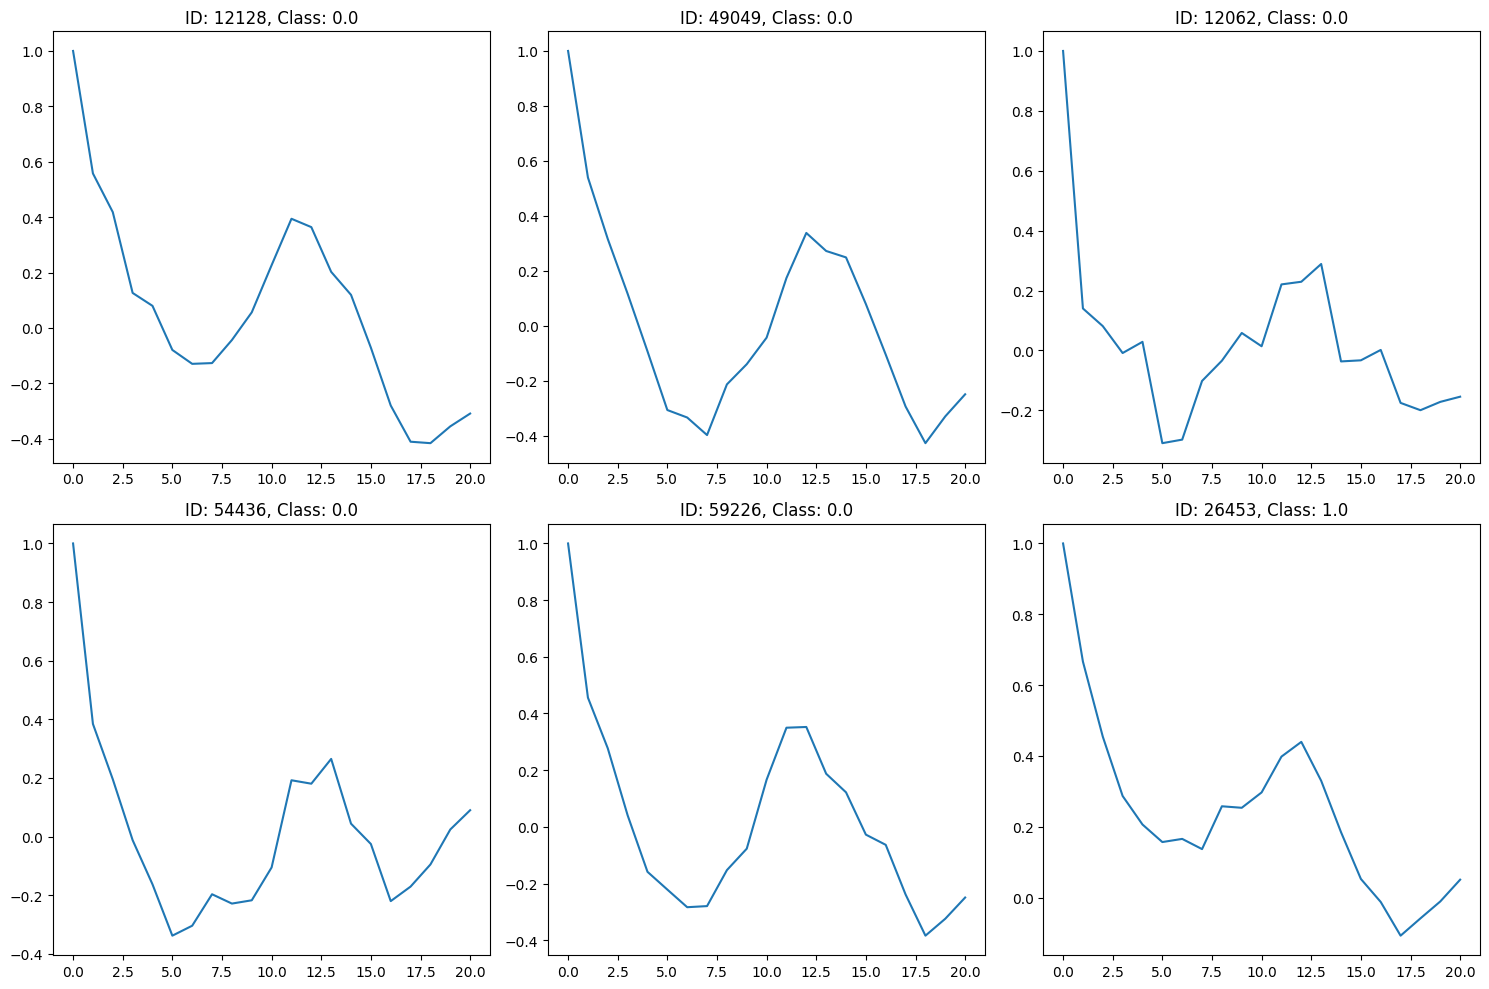

In [ ]:
# Визуализация автокорреляций для нескольких случайных временных рядов
sample_df = df_train.sample(6, random_state=4)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i, (idx, row) in enumerate(sample_df.iterrows()):
    ax = axes[i // 3, i % 3]
    ax.plot(np.arange(0, 21), row['acf_values'])
    ax.set_title(f"ID: {row['id']}, Class: {row['label']}")
plt.tight_layout()
plt.show()

## Проанализируем основные признаки и отберем наиболее полезные фичи

In [ ]:
# Функция для выделения признаков из каждого временного ряда
def extract_features(row):
    values = np.array(row['values'])
    start_date = pd.to_datetime(row['dates'][0])
    end_date = pd.to_datetime(row['dates'][-1])
    series_length = len(values)

    # Статистические признаки
    mean = np.mean(values)
    median = np.median(values)
    std = np.std(values)
    min_val = np.min(values)
    max_val = np.max(values)
    skewness = skew(values)

    # Признаки на основе разностей
    diff = np.diff(values)
    mean_diff = np.mean(diff)
    pos_diff_pct = np.sum(diff > 0) / len(diff)

    # Преобразование Фурье
    fft_vals = np.abs(fft(values))
    fft_features = fft_vals[:4]  # Берем первые 4 компоненты
    low_freq_energy = np.sum(fft_vals[:10])  # Энергия низкочастотных компонент

    # Вейвлет-преобразование
    wavelet = pywt.Wavelet('db1')
    coeffs = pywt.wavedec(values, wavelet, level=3)
    wavelet_features = np.hstack([np.mean(c) for c in coeffs[:-1]])

    # Прогнозируемость: ошибка линейной модели
    times = np.arange(len(values))
    slope, intercept, r_value, p_value, std_err = linregress(times, values)
    trend_line = intercept + slope * times

    # Остатки после линейной модели
    residuals = values - trend_line
    residual_mean = np.mean(residuals)
    residual_std = np.std(residuals)

    # Признаки на основе трендов
    trend_coef = slope  # Коэффициент тренда

    # Автокорреляция с лагами 1, 12 и 13
    autocorr_1 = np.corrcoef(values[:-1], values[1:])[0, 1]
    autocorr_12 = np.corrcoef(values[:-12], values[12:])[0, 1] if len(values) > 12 else np.nan

    # Декомпозиция временного ряда (тренд, сезонность, остатки)
    try:
        decomp = seasonal_decompose(values, period=12, model='additive', extrapolate_trend='freq')
        trend_mean = np.mean(decomp.trend)
    except ValueError:
        trend_mean = np.nan

    # Скользящие характеристики
    rolling_mean_3 = pd.Series(values).rolling(window=3).mean().mean()

    # Энтропия
    shannon_entropy = ent.shannon_entropy(values)

    # Дата начала и конца временного ряда, длина временного ряда
    start_day = start_date.day
    end_year = end_date.year
    end_month = end_date.month
    end_day = end_date.day

    # Собираем все фичи
    features = [mean, median, std, min_val, max_val, skewness,
                mean_diff, pos_diff_pct, trend_coef,
                autocorr_1, autocorr_12, trend_mean,
                low_freq_energy,
                residual_mean,
                rolling_mean_3,
                shannon_entropy,
                start_day, end_year, end_month, end_day, series_length]

    features.extend(fft_features)
    features.extend(wavelet_features)

    return pd.Series(features)

feature_columns = ['mean', 'median', 'std', 'min_val', 'max_val', 'skewness',
                   'mean_diff', 'pos_diff_pct', 'trend_coef',
                   'autocorr_1', 'autocorr_12', 'trend_mean',
                   'low_freq_energy',
                   'residual_mean',
                   'rolling_mean_3',
                   'shannon_entropy',
                    'start_day', 'end_year', 'end_month', 'end_day', 'series_length'] + \
                  [f'fft_{i}' for i in range(4)] + [f'wavelet_{i}' for i in range(3)]

tqdm.pandas(desc="Extracting features")
df_features = df_train.progress_apply(extract_features, axis=1)
df_features.columns = feature_columns

df_features['label'] = df_train['label']

Extracting features: 100%|██████████| 79912/79912 [08:02<00:00, 165.62it/s]


In [ ]:
df_features.head()

,mean,median,std,min_val,max_val,skewness,mean_diff,pos_diff_pct,trend_coef,autocorr_1,...,end_day,series_length,fft_0,fft_1,fft_2,fft_3,wavelet_0,wavelet_1,wavelet_2,label
0,0.023710,-0.110000,1.337272,-4.840000,3.49,-0.304166,0.021148,0.426230,-0.011222,-0.113649,...,1.0,62.0,1.470000,11.308932,4.484992,0.948133,0.017236,0.452106,0.332813,0.0
1,-0.310777,-0.274409,1.556337,-3.534409,2.92,-0.011952,0.022400,0.545455,-0.026755,0.189858,...,1.0,45.0,13.984957,19.890792,9.176199,3.948407,-0.833690,0.138925,-0.170833,1.0
2,-0.046042,-0.145000,1.065023,-1.950000,2.61,0.377148,-0.014894,0.489362,-0.032482,0.501409,...,1.0,48.0,2.210000,20.514392,5.375923,7.108244,-0.130225,-0.372999,-0.242917,0.0
3,-0.130000,-0.345000,1.158201,-2.220000,2.49,0.112395,0.040851,0.468085,0.049298,0.705215,...,1.0,48.0,6.240000,30.757721,4.131275,2.361102,-0.367696,-0.207418,-0.395000,0.0
4,-0.270536,-0.475000,1.270529,-2.500000,2.87,0.398655,-0.037455,0.509091,-0.011478,0.088913,...,1.0,56.0,15.150000,5.319692,2.669083,5.345714,-0.765191,-0.074246,0.550357,0.0


In [ ]:
df_features = df_features.dropna()

Посмотрим на корреляции pfi_k

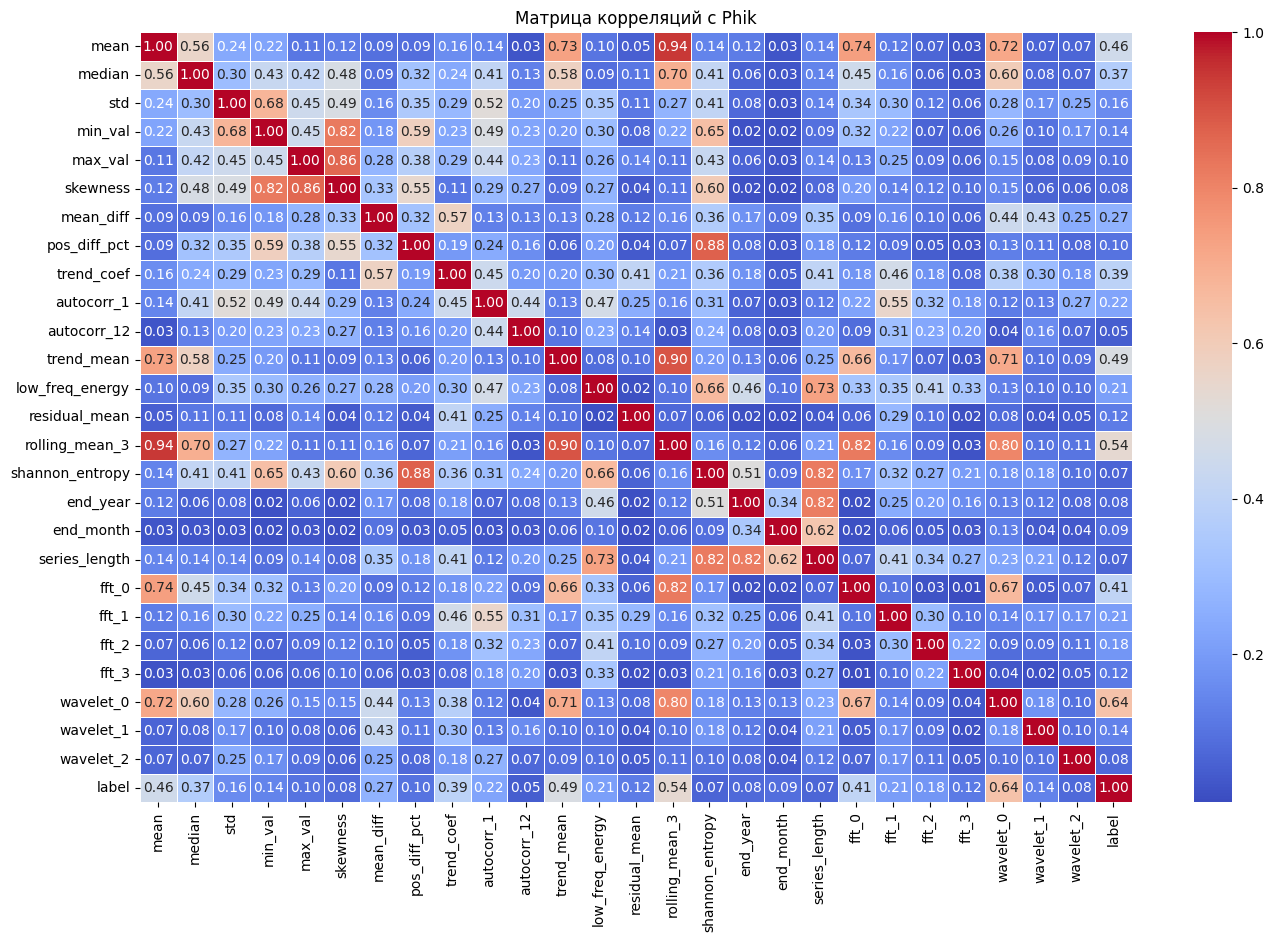

In [ ]:
phik_matrix = df_features.phik_matrix(interval_cols=df_features.columns)

# Матрица корреляций
plt.figure(figsize=(16, 10))
sns.heatmap(phik_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title('Матрица корреляций с Phik')
plt.show()

Некоторые признаки скореллированы. Но так как большинство признаков плохо кореллируют с таргетом, надежд, что справиться линейная модель - мало, поэтому мультиколлинеарность не так страшна, и чем больше признаком используем, тем будет лцучше, с расчетом на то, что сильная модель сама поймет что ей лучше и в какой мере использовать.

После отбора фиче получаем те, что представлены выше ( другие фичи были удалены из-за высокой корелляции (0.90+))

## Построение моделей

### Начнем с классификации по выделенным фичам

In [ ]:
X = df_features.drop(columns=['label'])
y = df_features['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

NameError: name 'df_features' is not defined

In [ ]:
def cross_validate_model(model, X, y, cv=4):
    scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv)
    return scores.mean()

In [ ]:
# Базовый набор моделей
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Support Vector Classifier': SVC(probability=True),
    'Decision Tree': DecisionTreeClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

In [ ]:
results = {}
for model_name, model in tqdm(models.items(), desc="Cross-Validating Models"):
    score = cross_validate_model(model, X_train, y_train)
    results[model_name] = score

results_df = pd.DataFrame(results, index=['ROC AUC']).T
print(results_df)

Cross-Validating Models: 100%|██████████| 8/8 [51:12<00:00, 384.07s/it]

                            ROC AUC
Logistic Regression        0.855461
Random Forest              0.889712
Gradient Boosting          0.888602
Support Vector Classifier  0.753293
Decision Tree              0.716972
K-Nearest Neighbors        0.703101
Naive Bayes                0.844888
XGBoost                    0.901084


Лучшее качество у XGboost

In [ ]:
ridge_classifier = RidgeClassifier()
ridge_scores = cross_val_score(ridge_classifier, X_train, y_train, scoring='roc_auc', cv=4)
print(f"Средний ROC AUC для Ridge Classifier: {ridge_scores.mean()}")

Средний ROC AUC для Ridge Classifier: 0.8623213555537225


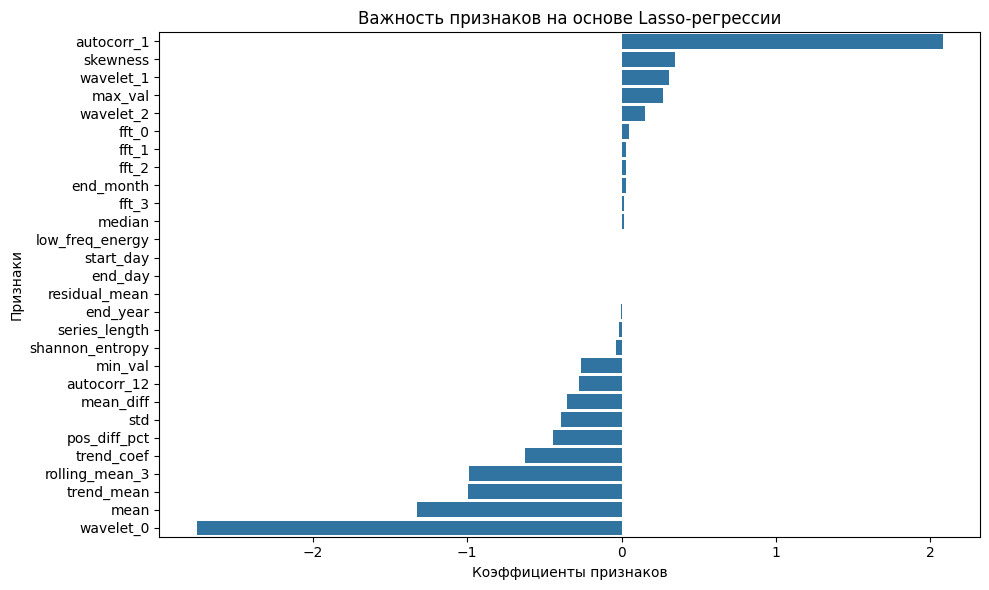

In [ ]:
# посмотрим на важность фичей с помощью Lasso
lasso_classifier = LogisticRegression(penalty='l2', solver='liblinear', max_iter=1000)
lasso_classifier.fit(X_train, y_train)

# Получение важности признаков
lasso_coefficients = pd.Series(lasso_classifier.coef_[0], index=X.columns)
lasso_coefficients_sorted = lasso_coefficients.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=lasso_coefficients_sorted.values, y=lasso_coefficients_sorted.index)
plt.title('Важность признаков на основе Lasso-регрессии')
plt.xlabel('Коэффициенты признаков')
plt.ylabel('Признаки')
plt.tight_layout()
plt.show()

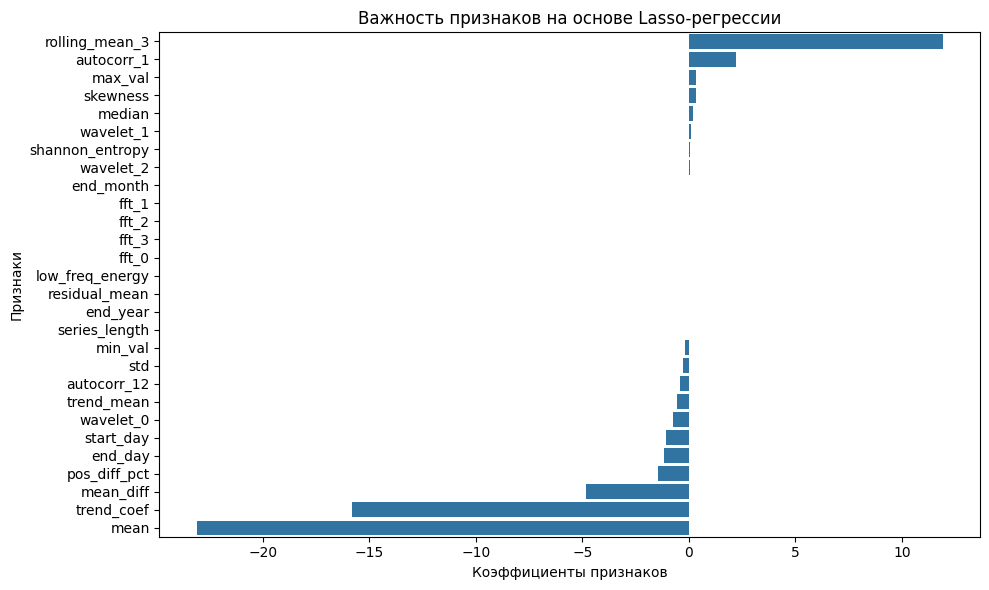

In [ ]:
# посмотрим на важность фичей с помощью Ridge
lasso_classifier = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)
lasso_classifier.fit(X_train, y_train)

# Получение важности признаков
lasso_coefficients = pd.Series(lasso_classifier.coef_[0], index=X.columns)
lasso_coefficients_sorted = lasso_coefficients.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=lasso_coefficients_sorted.values, y=lasso_coefficients_sorted.index)
plt.title('Важность признаков на основе Lasso-регрессии')
plt.xlabel('Коэффициенты признаков')
plt.ylabel('Признаки')
plt.tight_layout()
plt.show()

Как и было видно по EDA, основными значимыми признаками оказались коэффициент тренда, и средние значения

In [ ]:
# удалим колонки с самыми плохоми признаками
X = X.drop(columns=['residual_mean', 'start_day', 'end_day', 'low_freq_energy'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
class Grid():
    def __init__(self, model):
        self.model = model

    def grid_set(self, X, y,param_grid):
        grid_search = GridSearchCV(self.model, param_grid, cv=5,scoring="roc_auc")
        grid_search.fit(X,y)
        print(grid_search.best_params_, grid_search.best_score_)
        print(pd.DataFrame(grid_search.cv_results_)[["params", "mean_test_score", "std_test_score"]])

        return grid_search.best_estimator_

In [ ]:
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [3, 6, 9],
}



best_model = Grid(XGBClassifier(use_label_encoder=False, eval_metric='logloss')).grid_set(X_train,y_train,param_grid)
y_pred = best_model.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC AUC на тестовой выборке: {roc_auc}")

{'max_depth': 3, 'n_estimators': 200} 0.9050532723367981
                                  params  mean_test_score  std_test_score
0  {'max_depth': 3, 'n_estimators': 100}         0.900105        0.002913
1  {'max_depth': 3, 'n_estimators': 150}         0.903684        0.002764
2  {'max_depth': 3, 'n_estimators': 200}         0.905053        0.003018
3  {'max_depth': 6, 'n_estimators': 100}         0.902049        0.002476
4  {'max_depth': 6, 'n_estimators': 150}         0.901111        0.002577
5  {'max_depth': 6, 'n_estimators': 200}         0.900182        0.003088
6  {'max_depth': 9, 'n_estimators': 100}         0.897529        0.002127
7  {'max_depth': 9, 'n_estimators': 150}         0.898052        0.002055
8  {'max_depth': 9, 'n_estimators': 200}         0.899080        0.002232
ROC AUC на тестовой выборке: 0.7983833742497545


In [ ]:
param_grid = {
    'alpha': [0.1, 1.0, 10.0, 100.0]  # Значения регуляризации
}

best_model = Grid(RidgeClassifier()).grid_set(X_train,y_train,param_grid)
y_pred = best_model.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC AUC на тестовой выборке: {roc_auc}")

{'alpha': 0.1} 0.8623640564133218
             params  mean_test_score  std_test_score
0    {'alpha': 0.1}         0.862364        0.003092
1    {'alpha': 1.0}         0.862343        0.003054
2   {'alpha': 10.0}         0.861016        0.002827
3  {'alpha': 100.0}         0.856838        0.002511
ROC AUC на тестовой выборке: 0.7354625036774622


In [ ]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],



}


best_model = Grid(RandomForestClassifier()).grid_set(X_train,y_train,param_grid)
y_pred = best_model.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC AUC на тестовой выборке: {roc_auc}")

{'max_depth': 20, 'n_estimators': 200} 0.8905182585686294
                                   params  mean_test_score  std_test_score
0  {'max_depth': 10, 'n_estimators': 100}         0.883434        0.003183
1  {'max_depth': 10, 'n_estimators': 200}         0.884053        0.002892
2  {'max_depth': 20, 'n_estimators': 100}         0.888954        0.002803
3  {'max_depth': 20, 'n_estimators': 200}         0.890518        0.002584
ROC AUC на тестовой выборке: 0.7741495638220154


In [ ]:
param_grid_catboost = {
    'iterations': [300, 500],
    'depth': [4, 6, 8],


}
best_model = Grid(CatBoostClassifier(verbose=0)).grid_set(X_train,y_train,param_grid)
y_pred = best_model.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC AUC на тестовой выборке: {roc_auc}")

{'max_depth': 10, 'n_estimators': 200} 0.8985308236748383
                                   params  mean_test_score  std_test_score
0  {'max_depth': 10, 'n_estimators': 100}         0.887123        0.003761
1  {'max_depth': 10, 'n_estimators': 200}         0.898531        0.001864
2  {'max_depth': 20, 'n_estimators': 100}              NaN             NaN
3  {'max_depth': 20, 'n_estimators': 200}              NaN             NaN
ROC AUC на тестовой выборке: 0.7959871656761617


Пробить потолок в 0.8 моделями на основе выделенных признаков не получается

## Попробуем использовать модели, напрямую классифицирующие ряды

### LSTM

In [ ]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        values = np.array(self.data['values'].iloc[idx])
        label = self.data['label'].iloc[idx]
        return torch.tensor(values, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)


In [ ]:

df_train['values'] = df_train['values'].apply(lambda x: np.array(x))


max_length = df_train['values'].apply(len).max()


X = np.array([np.pad(v, (0, max_length - len(v)), 'constant') for v in df_train['values']])
y = df_train['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, dropout_rate=0.25):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True,dropout=dropout_rate)
        self.fc = nn.Linear(hidden_size, num_classes)


    def forward(self, x):
        # x: [batch_size, seq_length, input_size]
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # берем последний временной шаг
        return out


In [ ]:
# Параметры
input_size = 1  # одна фича (значение временного ряда)
hidden_size = 64
num_classes = 1
num_epochs = 3
batch_size = 32
learning_rate = 0.0002


train_dataset = TimeSeriesDataset(pd.DataFrame({'values': X_train.tolist(), 'label': y_train}))
test_dataset = TimeSeriesDataset(pd.DataFrame({'values': X_test.tolist(), 'label': y_test}))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


model = LSTMClassifier(input_size, hidden_size, num_classes)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Обучение модели
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs = inputs.unsqueeze(-1)  # добавляем размерность фичи
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/3], Loss: 0.5871
Epoch [2/3], Loss: 0.4880
Epoch [3/3], Loss: 0.5124


In [ ]:
# Оценка на тестовых данных
model.eval()
y_true = []
y_scores = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.unsqueeze(-1)
        outputs = model(inputs)
        predicted_scores = torch.sigmoid(outputs).squeeze().numpy()
        y_true.extend(labels.numpy())
        y_scores.extend(predicted_scores)


roc_auc = roc_auc_score(y_true, y_scores)
print(f'ROC AUC: {roc_auc:.4f}')


ROC AUC: 0.7266


LSTM пробила порог, но результат не сильно лучше, чем бейзлайновые модели